In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

import torch.nn.functional as F

In [2]:
# Veri artırma işlemleri tanımlanır.
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Rastgele yatay çevirme
    transforms.RandomRotation(10),     # Rastgele döndürme (10 dereceye kadar)
    transforms.RandomCrop(32, padding=4), # Rastgele kırpma (32x32 boyutunda, kenarlara 4 piksel ekleme)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Rastgele renk değiştirme
    transforms.ToTensor(), # Tensöre dönüştürme
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalleştirme
])


In [3]:
train_data = datasets.CIFAR10(
    root="cifar10_data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="cifar10_data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


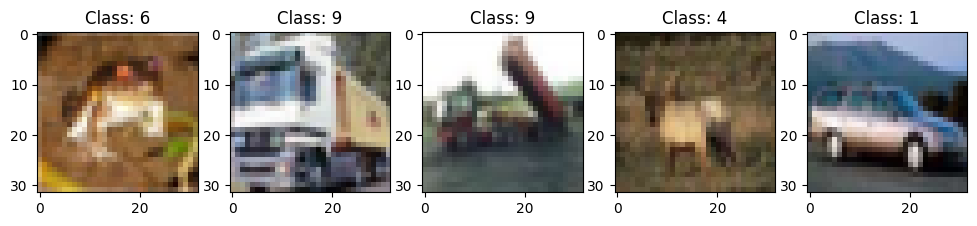

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))  # 1 satır, 5 sütunlu bir figür oluşturun

for i in range(5):  # İlk 5 görüntüyü çizin
    image, label = train_data[i]  # CIFAR-10 veri kümesinden bir görüntüyü ve etiketi alın
    axes[i].imshow(image.permute(1, 2, 0))  # Görüntüyü doğru formata dönüştürerek çizin
    axes[i].set_title(f"Class: {label}")  # Etiketi görüntünün başlığı olarak ayarlayın

plt.show()  # Görüntüleri gösterin







In [5]:
batch_size = 64
train_dl = DataLoader(train_data,batch_size)
test_dl = DataLoader(test_data,batch_size)

In [6]:
for x,y in test_dl:
    print("x:",x.shape)
    print("y:",y.shape)
    break

x: torch.Size([64, 3, 32, 32])
y: torch.Size([64])


In [7]:
if torch.cuda.is_available:
    device = 'cuda'
    print("device:",device)
else:
    print("device: CPU")
class NeuralNetworkCIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(32*32*3,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    def forward(self,x):
        x = self.flatten(x)
        output = self.model(x)
        return output
    
model = NeuralNetworkCIFAR10().to(device)
print(model)

device: cuda
NeuralNetworkCIFAR10(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

In [9]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    model.train()
    #Features and Labels have to be in the same device
    for batch,(x,y) in enumerate(dataloader):
        x,y = x.to(device),y.to(device)

        #compute prediction error
        pred = model(x)
        loss = loss_fn(pred,y)

        #backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss,current = loss.item(), (batch+1)*len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for x,y in dataloader:
            x,y = x.to(device),y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    

In [11]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl,model,loss_fn,optimizer)
    test(test_dl,model,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301239  [   64/50000]
loss: 2.297722  [ 6464/50000]
loss: 2.291775  [12864/50000]
loss: 2.295878  [19264/50000]
loss: 2.282303  [25664/50000]
loss: 2.279872  [32064/50000]
loss: 2.276631  [38464/50000]
loss: 2.273032  [44864/50000]
Test Error: 
 Accuracy: 16.7%, Avg loss: 2.269526 

Epoch 2
-------------------------------
loss: 2.283552  [   64/50000]
loss: 2.279399  [ 6464/50000]
loss: 2.246080  [12864/50000]
loss: 2.269982  [19264/50000]
loss: 2.242310  [25664/50000]
loss: 2.245382  [32064/50000]
loss: 2.253354  [38464/50000]
loss: 2.240213  [44864/50000]
Test Error: 
 Accuracy: 19.7%, Avg loss: 2.233969 

Epoch 3
-------------------------------
loss: 2.255411  [   64/50000]
loss: 2.250317  [ 6464/50000]
loss: 2.193343  [12864/50000]
loss: 2.239575  [19264/50000]
loss: 2.192922  [25664/50000]
loss: 2.199305  [32064/50000]
loss: 2.226860  [38464/50000]
loss: 2.189199  [44864/50000]
Test Error: 
 Accuracy: 21.5%, Avg loss: 2.184187 

Epoc

In [12]:
torch.save(model.state_dict(),"MineNeuralModel2CIFAR10.pth")
print("Saved model state to MineNeuralModel2CIFAR10.pth")

Saved model state to MineNeuralModel2CIFAR10.pth


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #64*16*16

            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self,x):
        return self.network(x)

In [15]:
modelCNN = net().to(device)
print(modelCNN)

net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=16384, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [16]:
optimizer = torch.optim.SGD(modelCNN.parameters(),lr=1e-3)

In [17]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl,modelCNN,loss_fn,optimizer)
    test(test_dl,modelCNN,loss_fn)
print("Done !")


Epoch 1
-------------------------------
loss: 2.288060  [   64/50000]
loss: 2.299510  [ 6464/50000]
loss: 2.308247  [12864/50000]
loss: 2.287502  [19264/50000]
loss: 2.296092  [25664/50000]
loss: 2.293986  [32064/50000]
loss: 2.293888  [38464/50000]
loss: 2.294718  [44864/50000]
Test Error: 
 Accuracy: 19.0%, Avg loss: 2.287670 

Epoch 2
-------------------------------
loss: 2.290974  [   64/50000]
loss: 2.291212  [ 6464/50000]
loss: 2.281010  [12864/50000]
loss: 2.278735  [19264/50000]
loss: 2.270308  [25664/50000]
loss: 2.268443  [32064/50000]
loss: 2.274295  [38464/50000]
loss: 2.267903  [44864/50000]
Test Error: 
 Accuracy: 21.5%, Avg loss: 2.258635 

Epoch 3
-------------------------------
loss: 2.272942  [   64/50000]
loss: 2.267202  [ 6464/50000]
loss: 2.232951  [12864/50000]
loss: 2.247755  [19264/50000]
loss: 2.219096  [25664/50000]
loss: 2.210572  [32064/50000]
loss: 2.229314  [38464/50000]
loss: 2.201262  [44864/50000]
Test Error: 
 Accuracy: 26.2%, Avg loss: 2.188285 

Epoc

In [ ]:
torch.save(model.state_dict(),"MineNeuralModel3CIFAR10.pth")
print("Saved model state to MineNeuralModel3CIFAR10.pth")